## Wind Analysis

In [22]:
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

%matplotlib inline

In [177]:
plt.rcParams['font.size'] = 12

In [158]:
def calc_sigma(Sal, TempC, P):
    """ Calculate rho: Based on SOG code
    """
    
    # Calculate the square root of the salinities
    sqrSal = np.sqrt(Sal)

    # Calculate the density profile at the grid point depths
    # Pure water density at atmospheric pressure
    # (Bigg P.H., (1967) Br. J. Applied Physics 8 pp 521-537)
    R1 = ((((6.536332e-9 * TempC - 1.120083e-6) * TempC + 1.001685e-4)
           * TempC - 9.095290e-3) * TempC + 6.793952e-2) * TempC - 28.263737
    R2 = (((5.3875e-9 * TempC - 8.2467e-7) * TempC + 7.6438e-5)
          * TempC - 4.0899e-3) * TempC + 8.24493e-1
    R3 = (-1.6546e-6 * TempC + 1.0227e-4) * TempC - 5.72466e-3

    # International one-atmosphere equation of state of seawater
    SIG = (4.8314e-4 * Sal + R3 * sqrSal + R2) * Sal + R1

    # Specific volume at atmospheric pressure
    V350P = 1.0 / 1028.1063
    SVA   = -SIG * V350P / (1028.1063 + SIG)

    # Density anomoly at atmospheric pressure
    sigma_t = 28.106331 - SVA / (V350P * (V350P + SVA))
    
    return sigma_t

In [ ]:
def reshape_grid(tmask, gridX, gridY):
    
    ngrid = tmask.shape[0] * tmask.shape[1]
    tmask = tmask.reshape(ngrid)
    ngrid_water = tmask.sum()
    gridX = gridX.reshape(ngrid)[tmask]
    gridY = gridY.reshape(ngrid)[tmask]
    
    return tmask, gridX, gridY, ngrid, ngrid_water

### Load Data
Load wind from ERDDAP

In [7]:
# Timerange
timerange = ['2016 Jan 1 00:00', '2016 Dec 31 23:00']
timeslice = slice(timerange[0], timerange[1])

# Load Wind
wind = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
u_wind = wind.sel(time=timeslice).u_wind.values.reshape(-1, ngrid_GEM)
v_wind = wind.sel(time=timeslice).v_wind.values.reshape(-1, ngrid_GEM)
u_wind_trim = np.zeros((u_wind.shape[0], ngrid_GEM_water))
v_wind_trim = np.zeros((v_wind.shape[0], ngrid_GEM_water))
for tindex, timerows in enumerate(zip(u_wind, v_wind)):
    u_wind_trim[tindex, :] = timerows[0][mask_GEM]
    v_wind_trim[tindex, :] = timerows[1][mask_GEM]
GEM = {
    'u_wind': u_wind_trim,
    'v_wind': v_wind_trim
}

Build NEMO coords

In [5]:
# Get mask and grid files
mask = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

# Mask
tmask = mask.tmask.isel(t=0).values.astype(bool)
tmask[:, 750:, :] = 0
tmask[:, :350, :] = 0
tmask[:, :, :100] = 0

# Grid
gridX, gridY = np.meshgrid(mask.x, mask.y)

# Full Grid Surface
tmask_full = tmask[0, :, :]
ngrid = tmask_full.shape[0] * tmask_full.shape[1]
tmask_full = tmask_full.reshape(ngrid)
ngrid_water = tmask_full.sum()
gridX_full = gridX.reshape(ngrid)[tmask_full]
gridY_full = gridY.reshape(ngrid)[tmask_full]

# Sub Grid Surface
tmask_sub_0 = tmask[0, ::5, ::5]
nsubgrid = tmask_sub_0.shape[0] * tmask_sub_0.shape[1]
tmask_sub_0 = tmask_sub_0.reshape(nsubgrid)
nsubgrid_water_0 = tmask_sub_0.sum()
gridX_sub_0 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_0]
gridY_sub_0 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_0]

# Sub Grid 20 m
tmask_sub_10 = tmask[18, ::5, ::5].reshape(nsubgrid)
nsubgrid_water_10 = tmask_sub_10.sum()
gridX_sub_10 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_10]
gridY_sub_10 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_10]

# Depth
deptht = mask.gdept_0.isel(t=0).values
deptht = deptht.reshape(-1, ngrid)[:, tmask_full]
dz = np.diff(deptht, axis=0)

Build wind mask

In [6]:
# Open NetCDF Files
grid_NEMO = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
grid_GEM  = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

# Preallocate
ngrid_GEM = grid_GEM.gridX.shape[0] * grid_GEM.gridY.shape[0]
mask_GEM = np.zeros(ngrid_GEM, dtype=int)

# Evaluate each point on GEM grid
for index, coords in enumerate(zip(
    grid_GEM.longitude.values.reshape(ngrid_GEM) - 360,
    grid_GEM.latitude.values.reshape(ngrid_GEM))):
    
    j, i = geo_tools.find_closest_model_point(coords[0], coords[1], grid_NEMO.nav_lon, grid_NEMO.nav_lat)
    if j is np.nan or i is np.nan:
        mask_GEM[index] = 0
    else:
        mask_GEM[index] = mask.tmask.isel(z=0, x=i, y=j).values

# Reshape
mask_GEM = mask_GEM.reshape(grid_GEM.longitude.shape)

# Mask out PS and JdF
mask_GEM[200:, :] = 0
mask_GEM[:110, :] = 0
mask_GEM[:140, :125] = 0

# Reshape
mask_GEM = mask_GEM.reshape(ngrid_GEM)

# Number of water points
ngrid_GEM_water = mask_GEM.sum()

# Convert to bool
mask_GEM = mask_GEM.astype(bool)

# GEM coordinates
X, Y = np.meshgrid(grid_GEM.gridX, grid_GEM.gridY)
X_full = X.reshape(ngrid_GEM)[mask_GEM]
Y_full = Y.reshape(ngrid_GEM)[mask_GEM]

Load NEMO 2016 results from pre-prepped matfile

In [19]:
# Load NEMO np.arrays from matfile
PCAdata = loadmat('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/NEMO_2016.mat')
with open(r'/ocean/bmoorema/research/MEOPAR/analysis-ben/data/GRIDMASK_2016', 'rb') as fid:
    GRIDMASK = pickle.load(fid)

### Analysis
Filter Tides

In [17]:
# Filter tides
PCAdata['u0_filter'] = tidetools.filter_timeseries(PCAdata['U0'], method='doodson')
PCAdata['v0_filter'] = tidetools.filter_timeseries(PCAdata['V0'], method='doodson')
GEM['u_wind_filter'] = tidetools.filter_timeseries(GEM['u_wind'], method='doodson')
GEM['v_wind_filter'] = tidetools.filter_timeseries(GEM['v_wind'], method='doodson')

Build Wind Indices

In [18]:
# Build wind indices
GEM['u_wind_rotated'], GEM['v_wind_rotated'] = viz_tools.rotate_vel(GEM['u_wind'], GEM['v_wind'], origin='map')
GEM['u_wind_filter_rotated'], GEM['v_wind_filter_rotated'] = viz_tools.rotate_vel(GEM['u_wind_filter'], GEM['v_wind_filter'], origin='map')
wind_index = GEM['v_wind_rotated'].mean(axis=1)
wind_index_filter = GEM['v_wind_filter_rotated'].mean(axis=1)

#### Wind Index and Surface Velocity Fields
The top plot is the alongstrait HRDPS wind timeseries averaged over the Strait of Georgia. The red dotted lines indicate the averaging thresholds (5 m/s and -5 m/s). The bottom left plot shows the surface currents averaged over southeasterly winds (> 5 m/s) and the bottom right plot shows the surface currents averaged over northwesterly winds (< -5 m/s). The red dotted lines plotted over the surface fields indicate the position of the cross-section plots shown next.

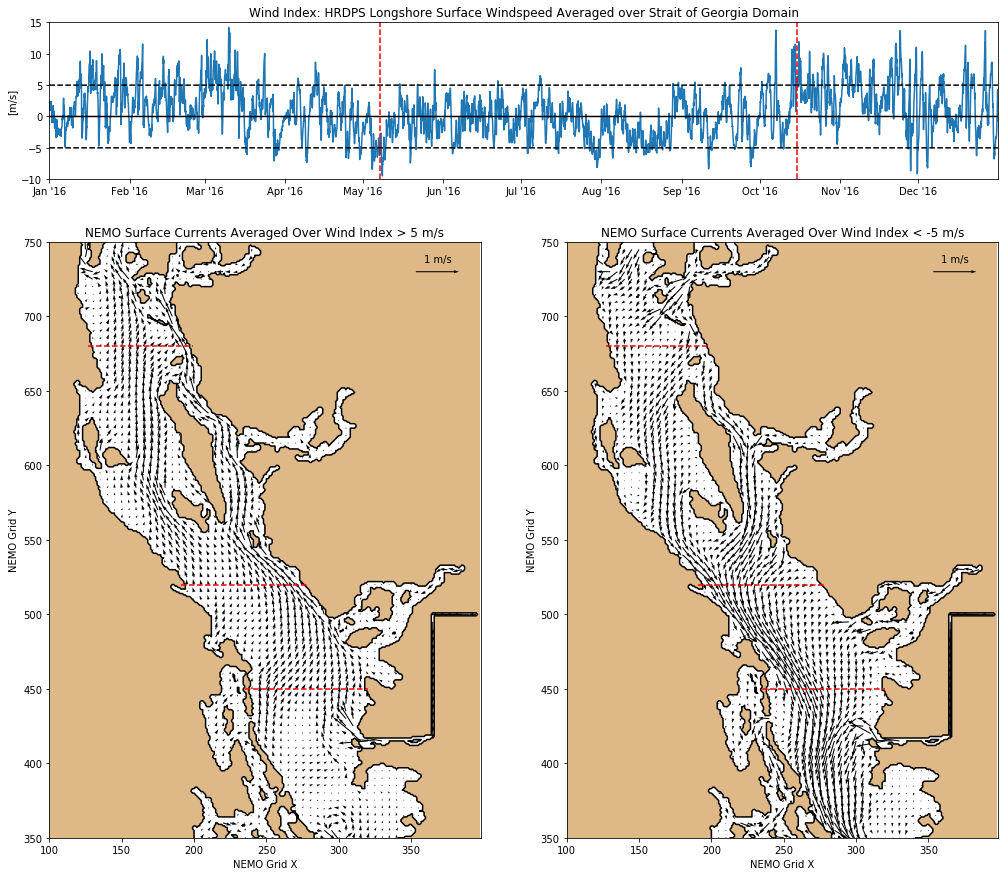

In [236]:
ax = [0, 0, 0]
date_NW = parse('2016 May 7 12:00')
date_SE = parse('2016 Oct 15 12:00')

fig = plt.figure(figsize=(17, 15))

gs = gridspec.GridSpec(4, 2)
gs.update(hspace=0.4)

ax[0] = plt.subplot(gs[0, :])
ax[1] = plt.subplot(gs[1:, 0])
ax[2] = plt.subplot(gs[1:, 1])

ax[0].plot(wind.time.sel(time=timeslice), wind_index)
ax[0].plot(wind.time.sel(time=timeslice), np.ones(wind_index.shape)*5, 'k--')
ax[0].plot(wind.time.sel(time=timeslice), np.ones(wind_index.shape)*-5, 'k--')
ax[0].plot(wind.time.sel(time=timeslice), np.zeros(wind_index.shape), 'k-')
ax[0].plot([date_NW, date_NW], [-10, 15], 'r--')
ax[0].plot([date_SE, date_SE], [-10, 15], 'r--')
ax[0].set_xlim(timerange)
ax[0].set_ylim([-10, 15])
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax[0].set_ylabel('[m/s]')
ax[0].set_title('Wind Index: HRDPS Longshore Surface Windspeed Averaged over Strait of Georgia Domain')

Q1 = ax[1].quiver(gridX_sub_0, gridY_sub_0, PCAdata['u0'][wind_index > 5, :].mean(axis=0),
                                       PCAdata['v0'][wind_index > 5, :].mean(axis=0), scale=10)
viz_tools.plot_land_mask(ax[1], grid_NEMO, color='burlywood')
viz_tools.plot_coastline(ax[1], grid_NEMO)
ax[1].plot([127, 199], [680, 680], 'r--')
ax[1].plot([191, 278], [520, 520], 'r--')
ax[1].plot([235, 320], [450, 450], 'r--')
ax[1].set_xlim([100, 398])
ax[1].set_ylim([350, 750])
ax[1].set_xlabel('NEMO Grid X')
ax[1].set_ylabel('NEMO Grid Y')
ax[1].set_title('NEMO Surface Currents Averaged Over Wind Index > 5 m/s')
plt.quiverkey(Q1, 0.9, 0.95, 1, '1 m/s')

Q2 = ax[2].quiver(gridX_sub_0, gridY_sub_0, PCAdata['u0'][wind_index < -5, :].mean(axis=0),
                                       PCAdata['v0'][wind_index < -5, :].mean(axis=0), scale=10)
viz_tools.plot_land_mask(ax[2], grid_NEMO, color='burlywood')
viz_tools.plot_coastline(ax[2], grid_NEMO)
ax[2].plot([127, 199], [680, 680], 'r--')
ax[2].plot([191, 278], [520, 520], 'r--')
ax[2].plot([235, 320], [450, 450], 'r--')
ax[2].set_xlim([100, 398])
ax[2].set_ylim([350, 750])
ax[2].set_xlabel('NEMO Grid X')
ax[2].set_ylabel('NEMO Grid Y')
ax[2].set_title('NEMO Surface Currents Averaged Over Wind Index < -5 m/s')
plt.quiverkey(Q2, 0.9, 0.95, 1, '1 m/s')

fig.savefig('/home/bmoorema/Desktop/WindComposite.eps', dpi=300, bbox_inches='tight')

#### Velocity and Density Cross-Sections
The left column plots are averaged over southeasterly winds (> 5 m/s) and the right column plots are averaged over northwesterly winds (< -5 m/s), consistent with the surface field plots above. The top row is the northern Strait, the middle row is the central Strait, and the bottom row is the Fraser plume area, as indicated by the red dotted lines on the surface fields above.

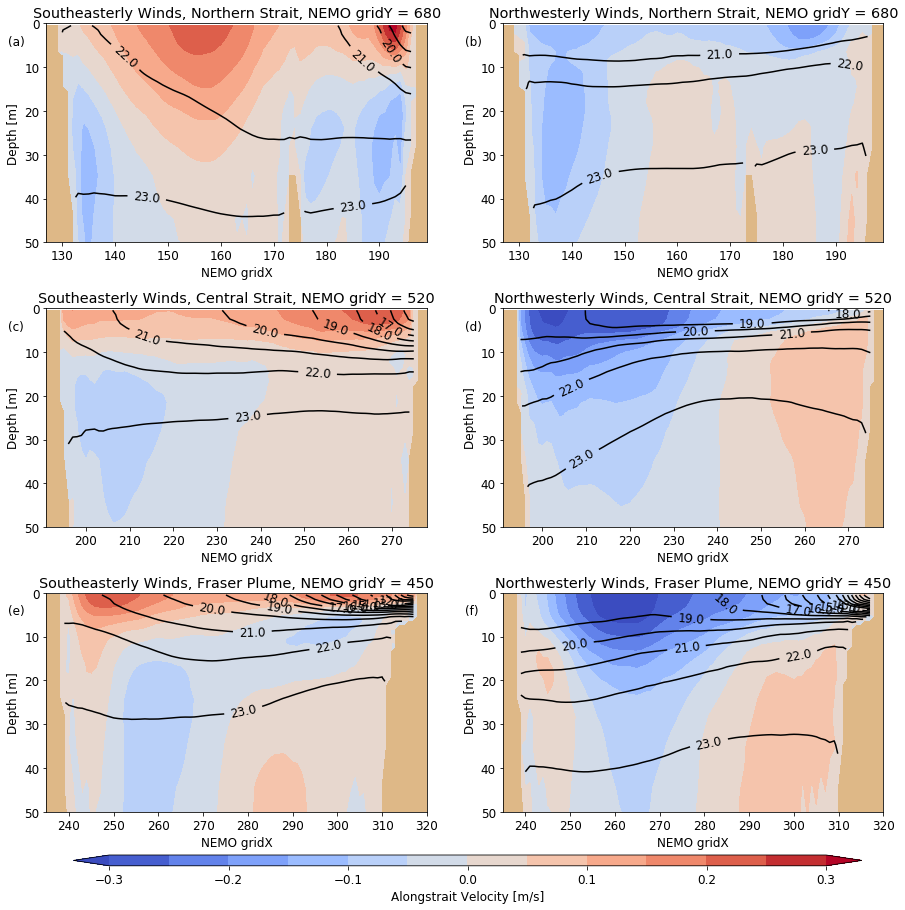

In [179]:
# Make figure and gridspec layout
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(3, 2)
gs.update(hspace=0.3)

# Fudge Wind Index
WINDEX = np.zeros(wind_index.shape)
WINDEX[888:-1] = wind_index[888:-1]

# Depth array
deptht = mask.gdept_1d.isel(t=0)

# Subplot array parameters
yN, yM, yS = 680, 520, 450
yN_lims = [127, 199]
yM_lims = [191, 278]
yS_lims = [235, 320]
axs = [0, 0, 0, 0, 0, 0]
locs = [[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]]
section = [yN, yM, yS, yN, yM, yS]
xlims = [yN_lims, yM_lims, yS_lims, yN_lims, yM_lims, yS_lims]
regions = ['Northern Strait', 'Central Strait', 'Fraser Plume',
           'Northern Strait', 'Central Strait', 'Fraser Plume']
plotletters = ['(a)', '(c)', '(e)', '(b)', '(d)', '(f)']

# Loop through subplots
for ax, loc, sec, xlim, region, plotletter in zip(axs, locs, section, xlims, regions, plotletters):
    
    # Wind averaging based on column
    if loc[1] > 0:
        windex = WINDEX < -5
        winddir = 'Northwesterly'
    else:
        windex = WINDEX > 5
        winddir = 'Southeasterly'
    
    # Calculate sigma
    Rho = calc_sigma(PCAdata[f'S{sec}'], PCAdata[f'T{sec}'], GRIDMASK[f'spc1_{sec}']['deptht'])
    
    # Reshape to grid
    V = np.zeros((PCAdata[f'V{sec}'].shape[0], deptht.shape[0], mask.x.shape[0]))
    RHO = np.zeros((rho.shape[0], deptht.shape[0], mask.x.shape[0]))
    for x, depth, v, rho in zip(GRIDMASK[f'spc1_{sec}']['gridX'], GRIDMASK[f'spc1_{sec}']['deptht'],
                              PCAdata[f'V{sec}'].T, Rho.T):
        V[:, abs(deptht - depth).argmin().values, x] = v
        RHO[:, abs(deptht - depth).argmin().values, x] = rho
    
    # Make axis
    ax = plt.subplot(gs[loc[0], loc[1]])
    
    C1 = ax.contourf(gridX, deptht, V[windex, :].mean(axis=0), levels=np.arange(-0.3, 0.35, 0.05), extend='both', cmap='coolwarm')
    C2 = ax.contour(gridX, deptht, np.ma.masked_values(RHO[windex, :].mean(axis=0), 0), levels=np.arange(0, 24), colors='k')
    ax.contourf(mask.tmask.x, mask.gdept_1d.isel(t=0), mask.tmask.isel(t=0, y=sec), [-0.01, 0.01], colors='burlywood')
    ax.set_xlim(xlim)
    ax.set_ylim([0, 50])
    ax.invert_yaxis()
    plt.clabel(C2, fmt='%.1f')
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('NEMO gridX')
    ax.set_title(f'{winddir} Winds, {region}, NEMO gridY = {sec}')
    ax.text(-.1, .9, plotletter, transform=ax.transAxes)
    
fig.subplots_adjust(bottom=0.15)
cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
fig.colorbar(C1, cax=cax, orientation='horizontal', extend='both', boundaries=[-1, 1], label='Alongstrait Velocity [m/s]')
fig.savefig('/home/bmoorema/Desktop/WindComposite_cross.eps', dpi=300, bbox_inches='tight')

#### Horizontal Currents at 10 m
Same averaging and layout as the surface currents

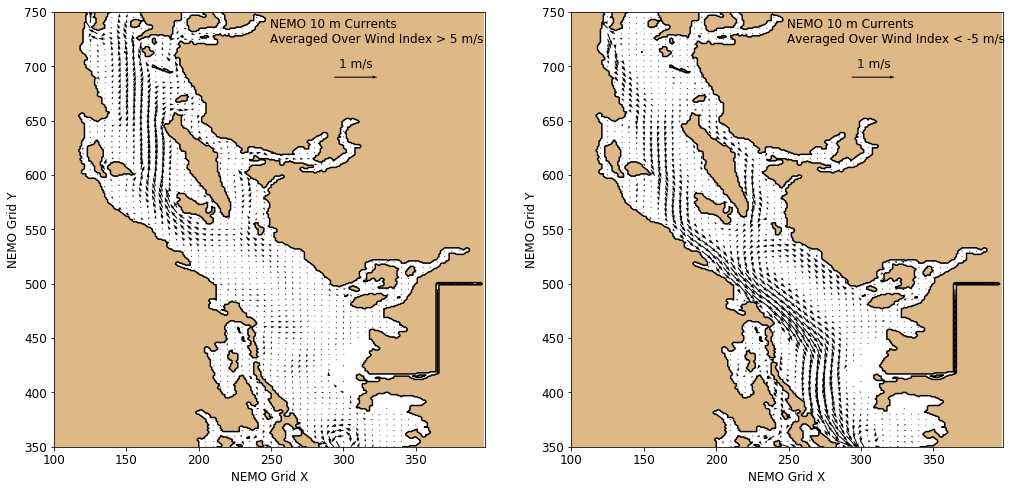

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
Q1 = ax[0].quiver(gridX_sub_10, gridY_sub_10, PCAdata['u10'][wind_index > 5, :].mean(axis=0),
                                       PCAdata['v10'][wind_index > 5, :].mean(axis=0), scale=10)
viz_tools.plot_land_mask(ax[0], grid_NEMO, color='burlywood')
viz_tools.plot_coastline(ax[0], grid_NEMO)
ax[0].set_xlim([100, 398])
ax[0].set_ylim([350, 750])
ax[0].set_xlabel('NEMO Grid X')
ax[0].set_ylabel('NEMO Grid Y')
ax[0].text(.5, .93, 'NEMO 10 m Currents \nAveraged Over Wind Index > 5 m/s', transform=ax[0].transAxes)
plt.quiverkey(Q1, 0.7, 0.85, 1, '1 m/s')


Q2 = ax[1].quiver(gridX_sub_10, gridY_sub_10, PCAdata['u10'][wind_index < -5, :].mean(axis=0),
                                       PCAdata['v10'][wind_index < -5, :].mean(axis=0), scale=10)
viz_tools.plot_land_mask(ax[1], grid_NEMO, color='burlywood')
viz_tools.plot_coastline(ax[1], grid_NEMO)
ax[1].set_xlim([100, 398])
ax[1].set_ylim([350, 750])
ax[1].set_xlabel('NEMO Grid X')
ax[1].set_ylabel('NEMO Grid Y')
ax[1].text(.5, .93, 'NEMO 10 m Currents \nAveraged Over Wind Index < -5 m/s', transform=ax[1].transAxes)
plt.quiverkey(Q2, 0.7, 0.85, 1, '1 m/s')

### Complex Principal Component Analysis

#### Complex Principal Component Analysis via SVD
Rattan and Hsieh 2005, *Neural Networks*

Let $\mathbf{Z}$ be a complex $m \times n$ ($m \le n$) matrix of rank $r$ ($r \le m$)

$$\mathbf{Z} = \mathbf{X} + i\mathbf{Y}$$

where $\mathbf{X}$ and $\mathbf{Y}$ are the real-valued respective u and v velocity fields.

Singular value decomposition (SVD) produces the relation

$$\mathbf{Z} = \mathbf{U}\mathbf{\Lambda}_{r}\mathbf{V}^\mathrm{H}$$

where the columns of $\mathbf{U}$ $(m \times r)$ are eigenvectors of $\mathbf{Z}\mathbf{Z}^\mathrm{H}$ (or scatter matrix)

the columns of $\mathbf{V}$ $(n \times r)$ are eigenvectors of $\mathbf{Z}^\mathrm{H}\mathbf{Z}$

and the main diagonal of $\mathbf{\Lambda}_{r}$ $(r \times r)$ contains the eigenvalues of both $\mathbf{Z}\mathbf{Z}^\mathrm{H}$ and $\mathbf{Z}^\mathrm{H}\mathbf{Z}$.

Thus for our purposes:

the $j$th column of $\mathbf{U}$ is our $j$th spatial pattern, loading, or EOF

the $j$th row of $\mathbf{\Lambda}_{r}\mathbf{V}^\mathrm{H}$ is our PC score or index for the $j$th mode

and the variance fraction explained by the $j$th mode is given by

$$\frac{\lambda_{j}^{2}}{\sum_{j=1}^{r}\lambda_{j}^{2}}$$

Since $\mathbf{\Lambda}_{r}\mathbf{V}^\mathrm{H}$ is complex, we can interpret the PC score as an amplitude and phase of variability.

We can obtain a $j$th mode prediction for $\mathbf{Z}$ $(\mathbf{Z}_{pred})$ using the SVD relation

$$\mathbf{Z}_{pred} = \sum_{j=1}^{r}\mathbf{u}_{j}\lambda_{j}\mathbf{v}_{j}^\mathrm{H}$$

#### Varimax Rotation

$$\mathbf{Z} = \mathbf{U}\mathbf{R}\mathbf{R}^{-1}\mathbf{A}^\mathrm{T} = \tilde{\mathbf{E}}\tilde{\mathbf{A}}^\mathrm{T}$$

$$\tilde{\mathbf{A}} = \mathbf{A}\mathbf{R}$$

In [61]:
# Find the currents anomaly
PCAdata['u0_filter_anomaly'] = PCAdata['u0_filter'] - PCAdata['u0_filter'].mean(axis=0)[np.newaxis, :]
PCAdata['v0_filter_anomaly'] = PCAdata['v0_filter'] - PCAdata['v0_filter'].mean(axis=0)[np.newaxis, :]

# Make the complex matrix
Z = PCAdata['u0_filter_anomaly'] + 1j * PCAdata['v0_filter_anomaly']

Complex PCA

In [62]:
# Singular value decomposition
U, L, V_H = np.linalg.svd(Z.T, full_matrices=False)

# Extract PCs
PC = np.angle(np.diag(L).dot(V_H), deg=True)
PC[PC < 0] = PC[PC < 0] + 360
PC[PC > 360] = PC[PC > 360] - 360

# Extract explained variance
PercentVar = L**2/(L**2).sum()

Plot Modes

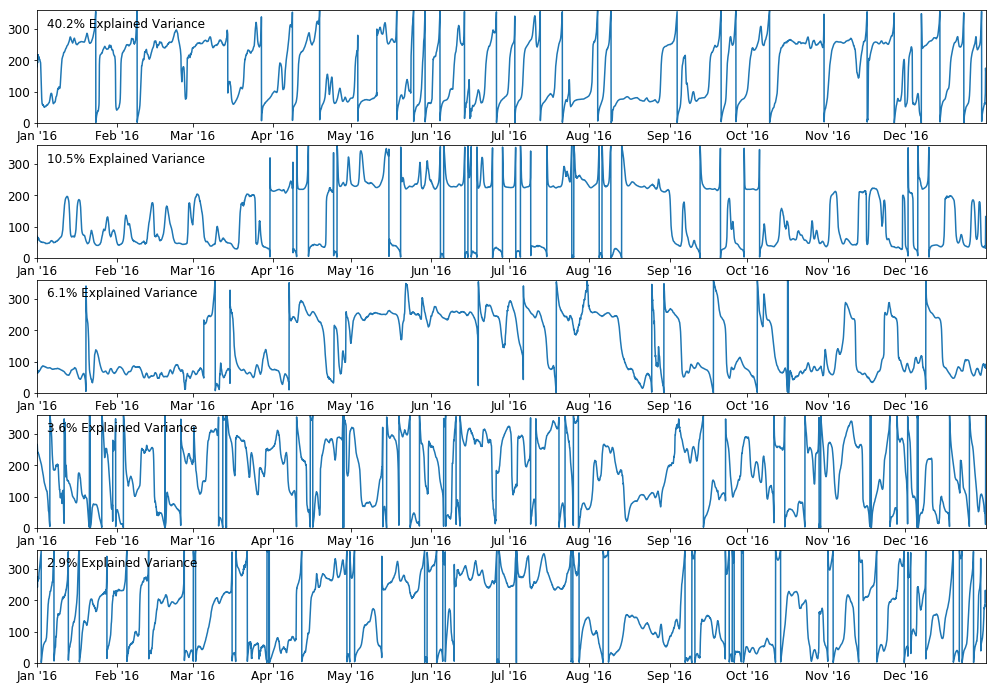

In [76]:
# Plot Modes
fig, axs = plt.subplots(5, 1, figsize=(17, 12))
for index, ax in enumerate(axs):
    ax.plot(wind.time.sel(time=timeslice), PC[index, :])
    ax.set_xlim(timerange)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    ax.set_ylim([0, 360])
    ax.text(.01, .85, '{:.1f}% Explained Variance'.format(PercentVar[index]*100), transform=ax.transAxes)

Extract Mode 1

In [87]:
# Create Mode 1 fields
Z_pred = U[:, 0, np.newaxis].dot(L[0] * V_H[np.newaxis, 0, :]).T

Mode 1 PC Scores and predicted fields

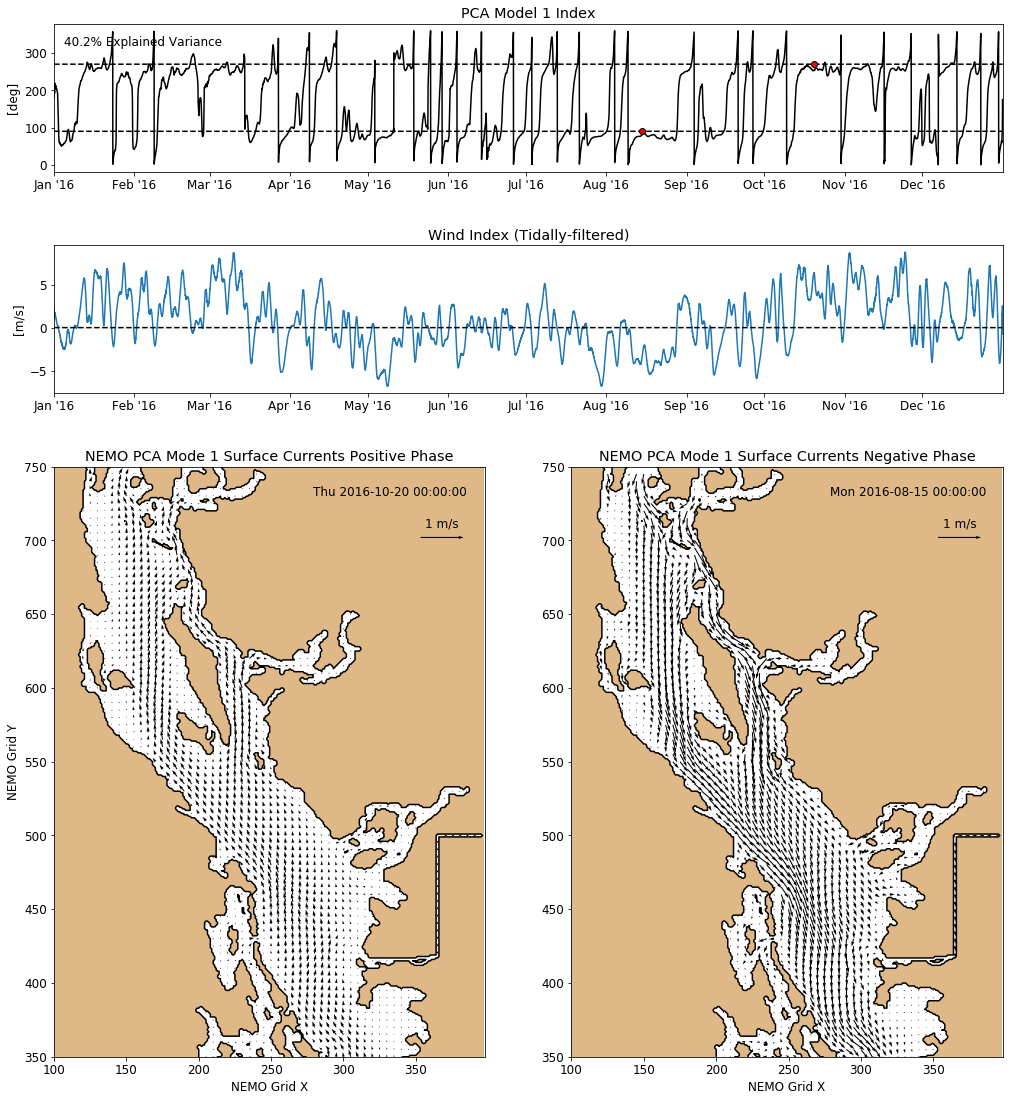

In [175]:
# Mode 2 PC Scores
ax = [0, 0, 0, 0]

fig = plt.figure(figsize=(17, 19))

gs = gridspec.GridSpec(5, 2)
gs.update(hspace=0.5)

ax[0] = plt.subplot(gs[0, :])
ax[1] = plt.subplot(gs[1, :])
ax[2] = plt.subplot(gs[2:, 0])
ax[3] = plt.subplot(gs[2:, 1])

ax[0].plot(wind.time.sel(time=timeslice), PC[0, :], 'k-')
ax[0].plot(wind.time.sel(time=timeslice), np.ones(PC[0, :].shape)*90, 'k--')
ax[0].plot(wind.time.sel(time=timeslice), np.ones(PC[0, :].shape)*270, 'k--')
ax[0].plot(wind.time.sel(time=timeslice).isel(time=5448), 90, 'ro', markeredgecolor='k')
ax[0].plot(wind.time.sel(time=timeslice).isel(time=7032), 270, 'ro', markeredgecolor='k')
ax[0].set_xlim(timerange)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax[0].text(.01, .85, '{:.1f}% Explained Variance'.format(PercentVar[0]*100), transform=ax[0].transAxes)
ax[0].set_title('PCA Model 1 Index')
ax[0].set_ylabel('[deg]')

ax[1].plot(wind.time.sel(time=timeslice), wind_index_filter)
ax[1].plot(wind.time.sel(time=timeslice), np.zeros(wind_index_filter.shape), 'k--')
ax[1].set_xlim(timerange)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax[1].set_ylabel('[m/s]')
ax[1].set_title('Wind Index (Tidally-filtered)')

Q1 = ax[2].quiver(gridX_sub_0, gridY_sub_0, Z_pred.real[7032], Z_pred.imag[7032], scale=10)
viz_tools.plot_land_mask(ax[2], grid_NEMO, color='burlywood')
viz_tools.plot_coastline(ax[2], grid_NEMO)
ax[2].set_xlim([100, 398])
ax[2].set_ylim([350, 750])
ax[2].set_xlabel('NEMO Grid X')
ax[2].set_ylabel('NEMO Grid Y')
ax[2].set_title('NEMO PCA Mode 1 Surface Currents Positive Phase')
ax[2].text(0.6, 0.95, nc_tools.xarraytime_to_datetime(wind.time.sel(time=timeslice).isel(time=7032)).strftime('%a %Y-%m-%d %H:%M:%S'),
           transform=ax[2].transAxes)
plt.quiverkey(Q1, 0.9, 0.88, 1, '1 m/s')

Q2 = ax[3].quiver(gridX_sub_0, gridY_sub_0, Z_pred.real[5448], Z_pred.imag[5448], scale=10)
viz_tools.plot_land_mask(ax[3], grid_NEMO, color='burlywood')
viz_tools.plot_coastline(ax[3], grid_NEMO)
ax[3].set_xlim([100, 398])
ax[3].set_ylim([350, 750])
ax[3].set_xlabel('NEMO Grid X')
ax[2].set_ylabel('NEMO Grid Y')
ax[3].set_title('NEMO PCA Mode 1 Surface Currents Negative Phase')
ax[3].text(0.6, 0.95, nc_tools.xarraytime_to_datetime(wind.time.sel(time=timeslice).isel(time=5448)).strftime('%a %Y-%m-%d %H:%M:%S'),
           transform=ax[3].transAxes)
plt.quiverkey(Q2, 0.9, 0.88, 1, '1 m/s')

fig.savefig('/home/bmoorema/Desktop/PCA.eps', dpi=300, bbox_inches='tight')